In [1]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt

import nxsdk.api.n2a as nx

from nxsdk.utils.plotutils import plotRaster
from msj_brain.asynch_eval import Callable

In [2]:
net = nx.NxNet()
# spike generators
gen = net.createSpikeGenProcess(numPorts=1)

nonlif_p = nx.CompartmentPrototype(vThMant=150, 
                                   compartmentCurrentDecay=4095,
                                   compartmentVoltageDecay=0)
nonlif = net.createCompartmentGroup(size=1, prototype=nonlif_p)

# Connect spike generator to compartment
gen_nonlif = nx.ConnectionPrototype(weight=10)
gen.connect(nonlif, prototype=gen_nonlif)

numSteps = 1000
gen.addSpikes(0, list())

# probes
u = nonlif.probe(nx.ProbeParameter.COMPARTMENT_CURRENT)[0][0]
v = nonlif.probe(nx.ProbeParameter.COMPARTMENT_VOLTAGE)[0][0]
s = nonlif.probe(nx.ProbeParameter.SPIKE)[0][0]

compiler = nx.N2Compiler()
board = compiler.compile(net)

In [3]:
# directory where SNIP C-code
includeDir = os.getcwd()
# Create SNIP
mgmtSnip = board.createProcess(
    name="runMgmt",
    includeDir=includeDir,
    cFilePath=includeDir + "/setVTh_core.c", # NxCore level C file
    funcName="runMgmt",
    guardName="doRunMgmt",
    phase="mgmt")

# channel: super host to Lakemont - new vTh values
# channel name: vThChannel, elements type: int, max capacity: 1 element
vThChannel = board.createChannel(b'vThChannel', "int", 1)
# Sending process is the super host (denoted by None) with mgmtSnip as the receiving process
vThChannel.connect(None, mgmtSnip)

# channel: Lakemont to super host - time of modification
# channel name: timeChannel, element type: int, max capacity: 1 element
timeChannel = board.createChannel(b'timeChannel', "int", 1)
# Sending process is the mgmtSnip and the receiving process is the super host (denoted by None)
timeChannel.connect(mgmtSnip, None)

# Start driver
board.startDriver()

INFO:DRV:  Connecting to 127.0.0.1:45049
INFO:DRV:      Host server up..............Done 0.02s
INFO:DRV:      Encoding axons/synapses.....Done 0.76ms
INFO:DRV:      Compiling Embedded snips....Done 0.11s


/home/negin/miniconda2/envs/loihi/lib/python3.5/site-packages/ipykernel_launcher.py:10: NxDeprecationWarning: createProcess will be removed in 0.9 in favor of createSnip
  # Remove the CWD from sys.path while we load stuff.
/home/negin/miniconda2/envs/loihi/lib/python3.5/site-packages/ipykernel_launcher.py:25: NxDeprecationWarning: startDriver is being deprecated. Use start instead.


INFO:HST:  Using Kapoho Bay serial number 435
INFO:HST:  Args chip=0 cpu=0 /home/negin/miniconda2/envs/loihi/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1619629473.136908/launcher_chip0_lmt0.bin --chips=1 --remote-relay=0 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 1.26s
INFO:DRV:      Encoding probes.............Done 1.64ms


In [4]:
times = []
vThVals = [100, 150, 200] 

# Add initial element in channel otherwise snip might miss it before Python on super host gets to send next element
vThChannel.write(1, [vThVals[0]])

# Launch execution
board.run(numSteps, aSync=True)

# Read time of last vTh modification from channel and write next vTh value to channel
for vth in vThVals[1:]:
    times.append(timeChannel.read(1)[0])
    vThChannel.write(1, [vth])

# Finish and disconnect
board.finishRun()
board.disconnect()

INFO:DRV:      Transferring probes.........Done 4.22ms
INFO:DRV:      Configuring registers.......Done 6.98ms
INFO:DRV:      Transferring spikes.........Done 1.71ms
INFO:HST:  chip=0 cpu=0 Executing management snip to change vTh
INFO:HST:  chip=0 cpu=0 Set vTh=100 at t=500
INFO:HST:  chip=0 cpu=0 Executing management snip to change vTh
INFO:DRV:      Executing...................Done 7.52ms
INFO:HST:  chip=0 cpu=0 Set vTh=150 at t=1000
INFO:DRV:      Processing timeseries.......Done 8.16ms
INFO:HST:  chip=0 cpu=0 halted, status=0x0


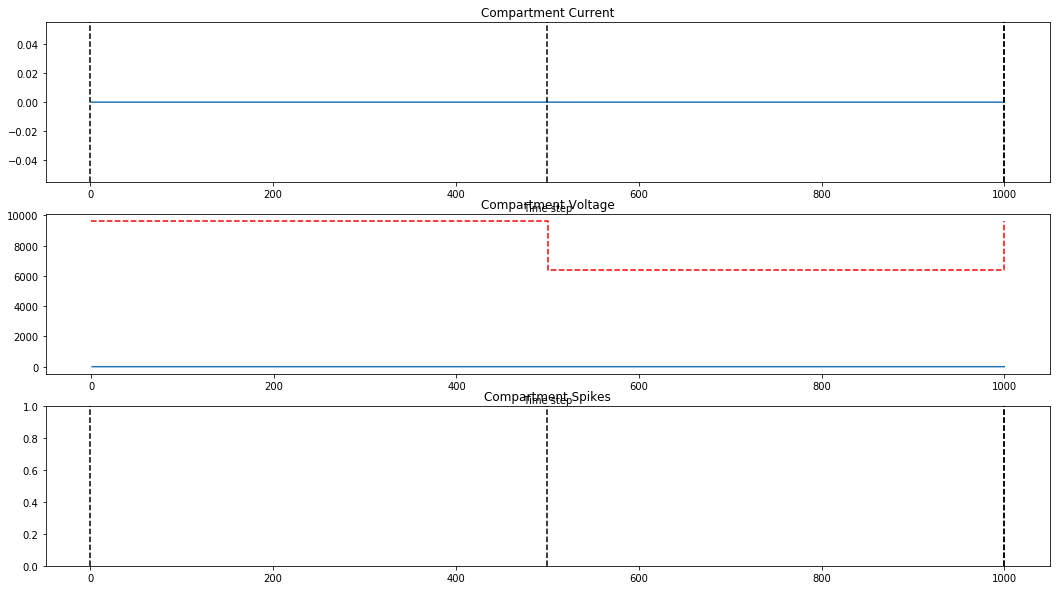

In [5]:
# Add initial and final values to 'times' and 'vThVals' that have not been sent for plotting
times.insert(0, 0)
times.append(1000)
vThVals.insert(0, 150)
vThVals.insert(0, 150)
vThVals = vThVals[:-1]

# Helper method to draw vertical interval separators whenever we change vTh
def drawIntervalSeperators(intervalBoundaries):
    for t in intervalBoundaries:
        plt.axvline(x=t, color='k', linestyle='--')

# Plot compartment current, voltage and spikes
plt.figure(1, figsize=(18,10))

ax1 = plt.subplot(3, 1, 1)
u.plot()
plt.title('Compartment Current')
drawIntervalSeperators(times)

ax2 = plt.subplot(3, 1, 2)
v.plot()
plt.title('Compartment Voltage')
plt.step(times, np.array(vThVals)*2**6, color='r', linestyle='--')

ax3 = plt.subplot(3, 1, 3)
s.plot()
plt.title('Compartment Spikes')
drawIntervalSeperators(times)
ax3.set_xlim(ax1.get_xlim())

plt.show()